In [2]:
# ==== RentVisionNYC — Modeling Notebook ====
# Works when this notebook is inside the Notebooks/ folder.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# --------------------------
# Paths (relative to Notebooks/)
# --------------------------
ROOT = ".."
DATA = os.path.join(ROOT, "Airbnb_Dataset", "processeddata", "nyc_airbnb_clean_with_rent.csv")
FIG_DIR = os.path.join(ROOT, "Reports", "figures")
OUT_METRICS = os.path.join(ROOT, "Reports", "model_metrics.csv")
os.makedirs(FIG_DIR, exist_ok=True)

print("Loading:", DATA)
df = pd.read_csv(DATA, low_memory=False)

# --------------------------
# Ensure numeric for key fields (coerce errors -> NaN)
# --------------------------
for c in [
    "price", "service_fee", "minimum_nights", "number_of_reviews",
    "price_per_night", "listing_density"
]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --------------------------
# One-hot room_type (dummy vars)
# --------------------------
room = pd.get_dummies(df["room_type"], prefix="room", dtype=float)
df = pd.concat([df, room], axis=1)

# Normalize possible label variants for room dummies
# We'll access them safely with DataFrame.get()
room_entire_col = "room_Entire home/apt"
room_private_col = "room_Private room"
room_shared_col = "room_Shared room"
room_hotel_col  = "room_Hotel room"

# --------------------------
# Neighborhood-level aggregation
# --------------------------
grp = df.groupby(["neighbourhood_group", "neighbourhood"], as_index=False)

feat = grp.agg(
    n_listings=("name", "count"),
    avg_price=("price", "mean"),
    avg_min_nights=("minimum_nights", "mean"),
    avg_reviews=("number_of_reviews", "mean"),
    avg_ppn=("price_per_night", "mean"),
    avg_service_fee=("service_fee", "mean"),
    density=("listing_density", "mean"),
)

# Add room shares (means of the dummies)
# Use .get to avoid KeyError if that dummy didn't exist in this data
feat["room_entire"]  = grp[room_entire_col].mean().get(room_entire_col, pd.Series(0.0))
feat["room_private"] = grp[room_private_col].mean().get(room_private_col, pd.Series(0.0))
feat["room_shared"]  = grp[room_shared_col].mean().get(room_shared_col, pd.Series(0.0))
feat["room_hotel"]   = grp[room_hotel_col].mean().get(room_hotel_col,  pd.Series(0.0))

# Target (median_rent) at neighborhood level
rent = grp["median_rent"].first().rename(columns={"median_rent": "median_rent"})
data = pd.merge(feat, rent, on=["neighbourhood_group", "neighbourhood"], how="left")
data = data.dropna(subset=["median_rent"]).reset_index(drop=True)

print("Neighborhood rows:", len(data))
print("Columns:", list(data.columns))

# --------------------------
# Plots for slides
# --------------------------
plt.figure()
plt.scatter(data["n_listings"], data["median_rent"])
plt.xlabel("Airbnb listings per neighborhood")
plt.ylabel("Median rent ($)")
plt.title("Listings vs. Median Rent (Neighborhood Level)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "scatter_listings_vs_rent.png"), dpi=200)
plt.close()

plt.figure()
data.groupby("neighbourhood_group")["median_rent"].mean().plot(kind="bar")
plt.ylabel("Average Median Rent ($)")
plt.xlabel("Borough")
plt.title("Average Median Rent by Borough")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "bar_rent_by_borough.png"), dpi=200)
plt.close()

# --------------------------
# Modeling
# --------------------------
X_cols = [
    "n_listings", "avg_price", "avg_service_fee", "avg_min_nights",
    "avg_reviews", "avg_ppn", "density",
    "room_entire", "room_private", "room_shared", "room_hotel"
]

# Clean X, y
X = data[X_cols].replace([np.inf, -np.inf], np.nan).fillna(0).astype(float)
y = data["median_rent"].astype(float).values

# Guard against any stray nans/infs
finite_mask = np.isfinite(y) & np.isfinite(X).all(axis=1)
X = X[finite_mask]
y = y[finite_mask]

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def evaluate(name, model):
    model.fit(Xtr, ytr)
    p_tr = model.predict(Xtr)
    p_te = model.predict(Xte)
    out = {
        "model": name,
        "R2_train": r2_score(ytr, p_tr),
        "R2_test":  r2_score(yte, p_te),
        "RMSE_train": rmse(ytr, p_tr),
        "RMSE_test":  rmse(yte, p_te),
    }
    print(out)
    return model, out

# Pipelines: scaling helps stabilize linear models
lin   = make_pipeline(StandardScaler(), LinearRegression())
ridge = make_pipeline(StandardScaler(), Ridge(alpha=10.0))
rf    = RandomForestRegressor(n_estimators=300, random_state=42)

lin,   m1 = evaluate("Linear+Scale", lin)
ridge, m2 = evaluate("Ridge(10)+Scale", ridge)
rf,    m3 = evaluate("RandomForest(300)", rf)

metrics = pd.DataFrame([m1, m2, m3]).sort_values("R2_test", ascending=False)
metrics.to_csv(OUT_METRICS, index=False)

print("\nSaved metrics to:", OUT_METRICS)
metrics

# --------------------------
# Optional: Feature importance (RF)
# --------------------------
try:
    imp = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=False)
    plt.figure()
    imp.plot(kind="bar")
    plt.title("Random Forest Feature Importance")
    plt.tight_layout()
    out_path = os.path.join(FIG_DIR, "rf_feature_importance.png")
    plt.savefig(out_path, dpi=200)
    plt.close()
    print("Saved feature importance to:", out_path)
    display(imp)
except Exception as e:
    print("Feature importance not available:", e)


Loading: ../Airbnb_Dataset/processeddata/nyc_airbnb_clean_with_rent.csv
Neighborhood rows: 224
Columns: ['neighbourhood_group', 'neighbourhood', 'n_listings', 'avg_price', 'avg_min_nights', 'avg_reviews', 'avg_ppn', 'avg_service_fee', 'density', 'room_entire', 'room_private', 'room_shared', 'room_hotel', 'median_rent']
{'model': 'Linear+Scale', 'R2_train': 0.29517332173903454, 'R2_test': 0.226822505108059, 'RMSE_train': 514.3284542477669, 'RMSE_test': 641.7204666193688}
{'model': 'Ridge(10)+Scale', 'R2_train': 0.29471332880591206, 'R2_test': 0.22323371477251264, 'RMSE_train': 514.4962606553335, 'RMSE_test': 643.2080512939648}
{'model': 'RandomForest(300)', 'R2_train': 0.9346689539719462, 'R2_test': 0.4445187518574343, 'RMSE_train': 156.5882571431596, 'RMSE_test': 543.9274664784657}

Saved metrics to: ../Reports/model_metrics.csv
Saved feature importance to: ../Reports/figures/rf_feature_importance.png


n_listings         0.281259
density            0.242382
room_private       0.095528
avg_min_nights     0.094289
avg_ppn            0.085933
room_entire        0.075849
avg_reviews        0.058845
avg_price          0.041073
room_shared        0.017198
room_hotel         0.007644
avg_service_fee    0.000000
dtype: float64

In [3]:
import os, glob
print("CWD:", os.getcwd())
print("Figures:", glob.glob("../Reports/figures/*.png"))


CWD: /Users/jainam/Downloads/Class_Fall_25/FDS/RentVisionNYC/Notebooks
Figures: ['../Reports/figures/bar_rent_by_borough.png', '../Reports/figures/scatter_listings_vs_rent.png', '../Reports/figures/rf_feature_importance.png']


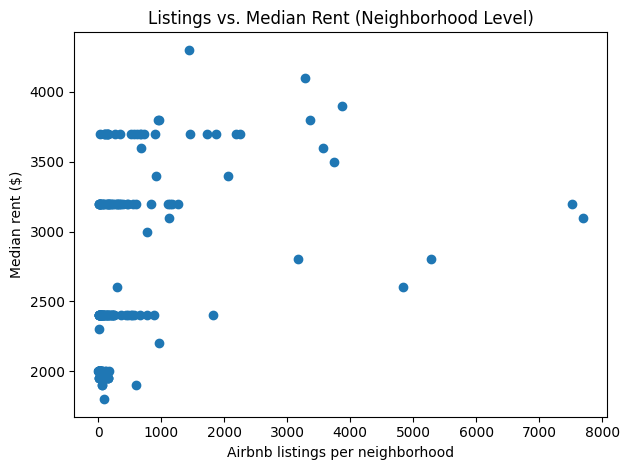

<Figure size 640x480 with 0 Axes>

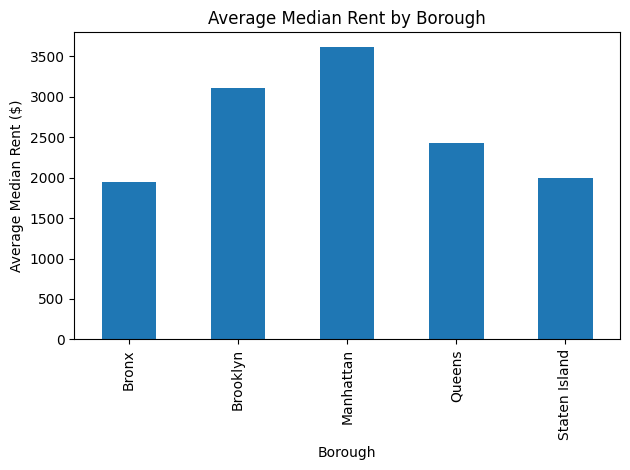

Saved to: ../Reports/figures


<Figure size 640x480 with 0 Axes>

In [4]:
# Inline display + save copies for slides
%matplotlib inline
import os, pandas as pd, matplotlib.pyplot as plt

ROOT = ".."                         # adjust only if your notebook isn't in Notebooks/
DATA = f"{ROOT}/Airbnb_Dataset/processeddata/nyc_airbnb_clean_with_rent.csv"
FIG_DIR = f"{ROOT}/Reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

df = pd.read_csv(DATA, low_memory=False)

# Neighborhood aggregation (matches modeling)
room = pd.get_dummies(df["room_type"], prefix="room", dtype=float)
df = pd.concat([df, room], axis=1)
grp = df.groupby(["neighbourhood_group","neighbourhood"], as_index=False)

nhood = grp.agg(
    n_listings=("name","count"),
    median_rent=("median_rent","first"),
)

# ---- 1) Listings vs Rent (scatter) ----
plt.figure()
plt.scatter(nhood["n_listings"], nhood["median_rent"])
plt.xlabel("Airbnb listings per neighborhood")
plt.ylabel("Median rent ($)")
plt.title("Listings vs. Median Rent (Neighborhood Level)")
plt.tight_layout()
plt.show()
plt.savefig(f"{FIG_DIR}/scatter_listings_vs_rent.png", dpi=200)

# ---- 2) Avg Rent by Borough (bar) ----
plt.figure()
df.groupby("neighbourhood_group")["median_rent"].mean().plot(kind="bar")
plt.ylabel("Average Median Rent ($)")
plt.xlabel("Borough")
plt.title("Average Median Rent by Borough")
plt.tight_layout()
plt.show()
plt.savefig(f"{FIG_DIR}/bar_rent_by_borough.png", dpi=200)

print("Saved to:", FIG_DIR)
